In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

DATAFILE = '../data/1/previous_heats_with_properties.json'
scrap = ['bushling','pig_iron','municipal_shred','skulls']

In [2]:
def load_data(datafile):
    """loads the .json file as dataframe
    
    args:
        datafile: file path
        
    returns: 
        dataframe
    """
    df_previous_heat = pd.read_json (datafile)
    return df_previous_heat

In [3]:
def data_preprocessing(df):
    """clean up the data and process it before considering
    
    args:
        df : dataframe
        
    returns: 
        df: processed dataframe
    """
    df['cu_pct'] =   pd.DataFrame(df.chemistry.values.tolist(), 
                                            index= df.index)
    df[scrap] = pd.DataFrame(df.actual_recipe.values.tolist(), 
                                            index= df.index)
    df = df.drop(['chemistry','actual_recipe'], axis=1)
    df['scrap_wgt'] = df[['bushling','pig_iron','municipal_shred','skulls']].sum(axis=1)
    df['total_wgt'] = df[scrap].sum(axis=1)
    df['steel_grade'] = df[['steel_grade']].replace(['ST1','ST2','ST3'], [1,2,3])
    for val in scrap:   
        df[val+'_norm'] = df[val]/df['total_wgt']
    return df

In [4]:
def plot_me(df):
    """plots the grapgh
    
    args:
        df : data to plot
    """
    df.plot(x = 'cu_pct', y = scrap, kind="bar")
    

In [5]:
def split_data(df):
    """Split the data for testing and training
    
    args:
        df: dataframe
        
    returns: 
        X_train: input parameters for training the model
        X_test:  input parameters for testing the model
        y_train: target for the training the model
        y_test:  target for testing the model
    """
    x = df[['heat_seq','tap_weight','bushling','pig_iron','municipal_shred','skulls']]
    y = df[['cu_pct']]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
    
    return X_train, X_test, y_train, y_test



In [6]:
def cu_estimator_lr(X_train, y_train):
    """train linear regression model and save it
    
    args:
        X_train: input parameters for training the model
        y_train: target for the training the model
    
    returns:
        cu_estimator: trained model 
        filename: saved model name
        """
   
    cu_estimator = LinearRegression()  
    cu_estimator= cu_estimator.fit(X_train, y_train)   #training the algorithm
    filename = 'cu_estimator_model.sav'
    pickle.dump(cu_estimator, open(filename, 'wb'))
    return cu_estimator, filename

In [7]:
def test_model(filename):
    """test the model
    
    args:
       filename: name of the saved model
    
    returns:
        y_pred : predicted values
        """
    loaded_model = pickle.load(open(filename, 'rb'))
    y_pred = loaded_model.predict(X_test)
    return y_pred

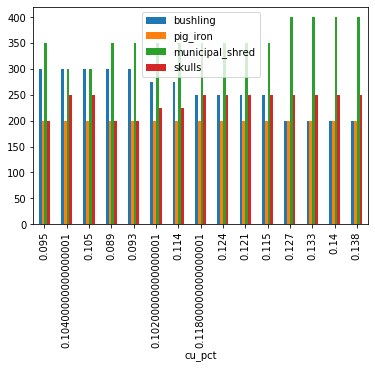

In [8]:
df = load_data(DATAFILE)
df = data_preprocessing(df)
plot_me(df)

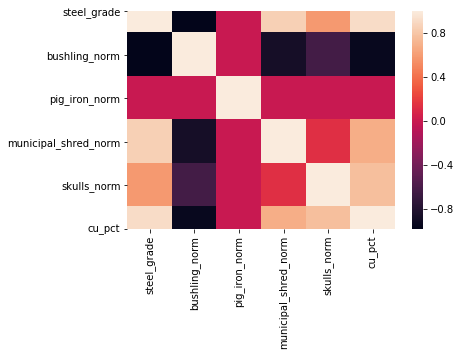

In [9]:
sns.heatmap(df[['steel_grade','bushling_norm','pig_iron_norm','municipal_shred_norm','skulls_norm'] + ['cu_pct']].corr())

In [10]:
X_train, X_test, y_train, y_test = split_data(df)
trained_model, name = cu_estimator_lr(X_train, y_train)

y_pred = test_model(name)
y_test= y_test.to_numpy()
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df

,Actual,Predicted
0,0.104,0.103967
1,0.114,0.101834
2,0.124,0.119006
